In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 300.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.5, .55, .85/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 1e-24

include 'trp75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

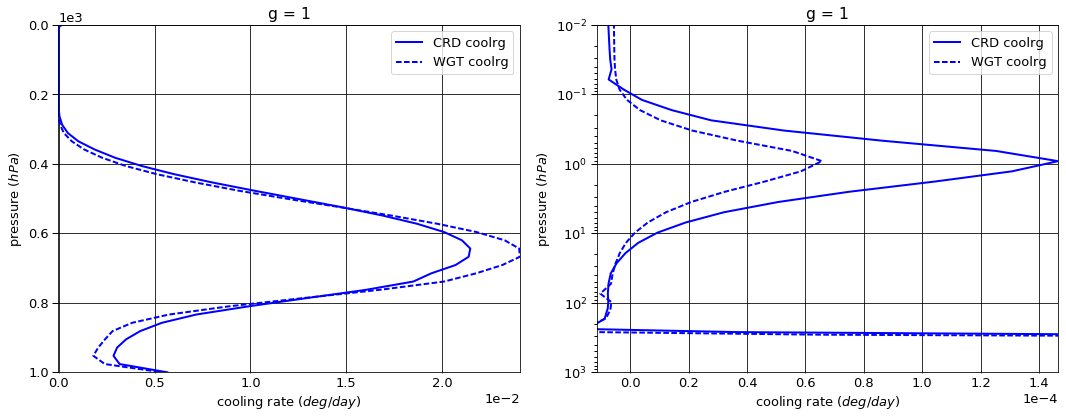

# Figure: cooling rate g-group 2

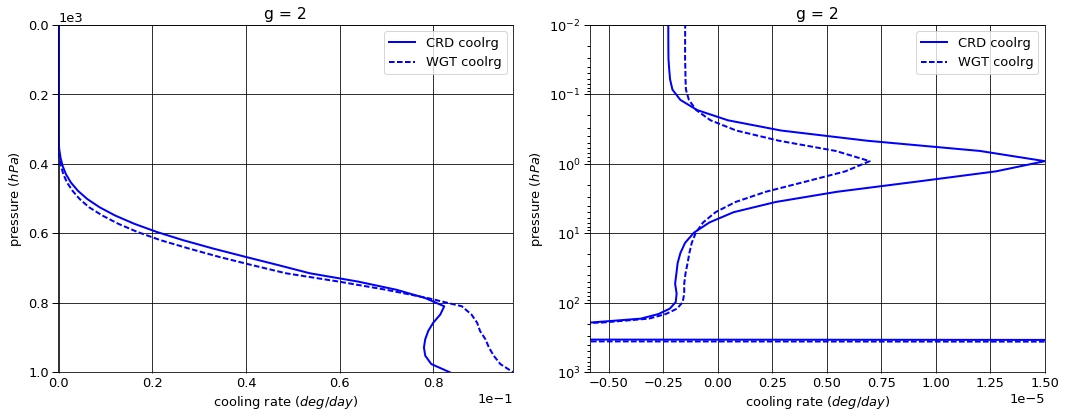

# Figure: cooling rate g-group 3

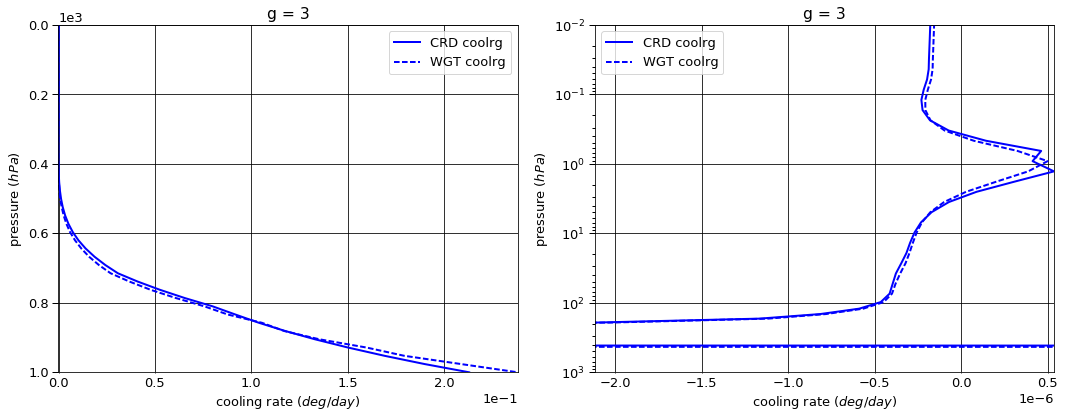

# Figure: cooling rate g-group total

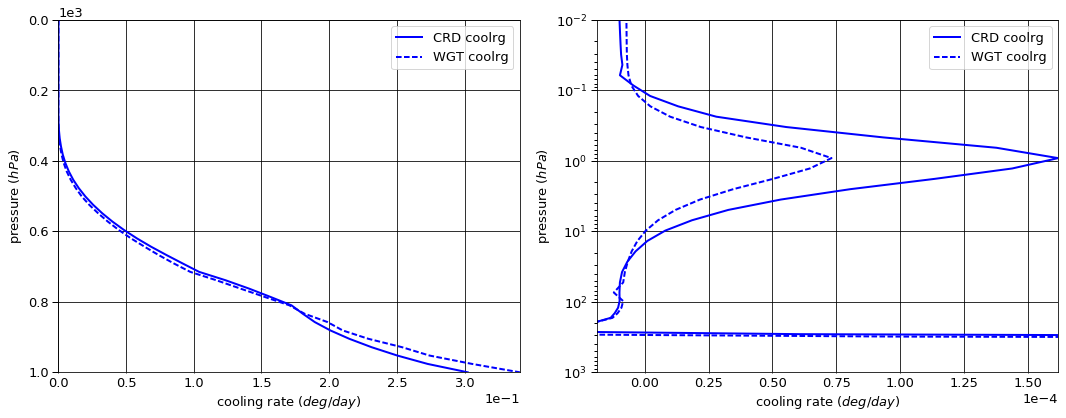

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.911399  0.000000  -0.911399
  1013.0   76     -1.370368  1.344950  -0.025418
2 0.0      1      -4.993151  0.000000  -4.993151
  1013.0   76     -5.794373  4.203143  -1.591230
3 0.0      1     -59.547861  0.000000 -59.547861
  1013.0   76    -60.184709  4.936534 -55.248176


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.911563  0.000000  -0.911563
  1013.0   76     -1.370368  1.350264  -0.020105
2 0.0      1      -5.027013  0.000000  -5.027013
  1013.0   76     -5.794373  4.312748  -1.481625
3 0.0      1     -59.569378  0.000000 -59.569378
  1013.0   76    -60.184709  4.989431 -55.195278


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000164  0.000000 -0.000164
  1013.0   76     0.000000  0.005313  0.005313
2 0.0      1     -0.033863  0.000000 -0.033863
  1013.0   76     0.000000  0.109605  0.109605
3 0.0      1     -0.021517  0.000000 -0.021517
  1013.0   76     0.000000  0.052898  0.052898

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.389248e-06
  1001.112500 75     5.663035e-03
2 0.000312    1     -2.250075e-06
  1001.112500 75     8.354871e-02
3 0.000312    1     -1.592761e-07
  1001.112500 75     2.131548e-01


WGT


coolrg
g pressure    layer              
1 0.000312    1     -5.769118e-06
  1001.112500 75     5.389871e-03
2 0.000312    1     -1.463157e-06
  1001.112500 75     9.707488e-02
3 0.000312    1     -1.389103e-07
  1001.112500 75     2.383874e-01


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.620129e-06
  1001.112500 75    -2.731639e-04
2 0.000312    1      7.869182e-07
  1001.112500 75     1.352616e-02
3 0.000312    1      2.036582e-08
  1001.112500 75     2.523254e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.452411,0.000000,-65.452411
1013.0,76,-67.349450,10.484627,-56.864823



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.507955,0.000000,-65.507955
1013.0,76,-67.349450,10.652443,-56.697007



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.055544,0.000000,-0.055544
1013.0,76,0.000000,0.167816,0.167816


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.302367



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.340852



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000003
1001.112500,75,0.038486


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.570719e-23  5.376453e-25  29.214784
      2     0.000312  4.909078e-25  1.356834e-26  36.180391
      3     0.000312  2.227429e-27  2.460757e-29  90.518043
2     1     0.000750  1.585282e-23  5.392301e-25  29.398997
      2     0.000750  4.944643e-25  1.361470e-26  36.318406
      3     0.000750  2.252706e-27  2.477125e-29  90.940345
3     1     0.001052  1.615216e-23  5.422738e-25  29.785987
      2     0.001052  5.018062e-25  1.370436e-26  36.616536
      3     0.001052  2.304847e-27  2.504722e-29  92.020084
4     1     0.001476  1.646130e-23  5.453828e-25  30.183014
      2     0.001476  5.094164e-25  1.379550e-26  36.926270
      3     0.001476  2.359043e-27  2.534244e-29  93.086654
5     1     0.002070  1.677625e-23  5.485317e-25  30.583914
      2     0.002070  5.171984e-25  1.388738e-26  37.242316
      3     0.002070  2.414626e-27  2.565925e-29  94.103512
6     1     0.002904  1.709699e-23  5.517428e-25  30.987245
      2     0.002904  5.251529e-25  1.398067e-26  37.562793
      3     0.002904  2.471618e-27  2.600608e-29  95.040002
7     1     0.004074  1.742355e-23  5.550494e-25  31.390986
      2     0.004074  5.332812e-25  1.407631e-26  37.885007
      3     0.004074  2.530056e-27  2.639511e-29  95.853206
8     1     0.005714  1.775618e-23  5.585013e-25  31.792548
      2     0.005714  5.415895e-25  1.417575e-26  38.205347
      3     0.005714  2.590018e-27  2.684380e-29  96.484798
9     1     0.008015  1.809478e-23  5.621643e-25  32.187702
      2     0.008015  5.500744e-25  1.428091e-26  38.518175
      3     0.008015  2.651532e-27  2.737659e-29  96.853961
10    1     0.011243  1.843947e-23  5.661344e-25  32.570825
      2     0.011243  5.587365e-25  1.439457e-26  38.815785
      3     0.011243  2.714670e-27  2.802832e-29  96.854539
11    1     0.015771  1.879029e-23  5.705461e-25  32.933867
      2     0.015771  5.675725e-25  1.452067e-26  39.087204
      3     0.015771  2.779511e-27  2.884804e-29  96.350105
12    1     0.022122  1.914734e-23  5.755892e-25  33.265630
      2     0.022122  5.765774e-25  1.466478e-26  39.317162
      3     0.022122  2.846158e-27  2.990468e-29  95.174354
13    1     0.031031  1.951190e-23  5.815399e-25  33.552123
      2     0.031031  5.857732e-25  1.483498e-26  39.485937
      3     0.031031  2.914970e-27  3.129567e-29  93.142914
14    1     0.043528  1.998622e-23  5.895863e-25  33.898717
      2     0.043528  5.977931e-25  1.506582e-26  39.678755
      3     0.043528  3.005362e-27  3.325214e-29  90.381031
15    1     0.061057  2.174072e-23  6.091752e-25  35.688783
      2     0.061057  6.435341e-25  1.563443e-26  41.161337
      3     0.061057  3.343627e-27  3.717832e-29  89.934867
16    1     0.085645  2.566763e-23  6.451960e-25  39.782693
      2     0.085645  7.504967e-25  1.672793e-26  44.864891
      3     0.085645  4.138912e-27  4.467359e-29  92.647843
17    1     0.120136  3.113394e-23  6.908908e-25  45.063483
      2     0.120136  9.094512e-25  1.826494e-26  49.792168
      3     0.120136  5.337318e-27  5.631123e-29  94.782478
18    1     0.168516  3.774610e-23  7.454709e-25  50.633900
      2     0.168516  1.117020e-24  2.030604e-26  55.009228
      3     0.168516  6.930330e-27  7.348566e-29  94.308595
19    1     0.236378  4.569309e-23  8.158510e-25  56.006661
      2     0.236378  1.387678e-24  2.310968e-26  60.047456
      3     0.236378  9.054832e-27  9.924588e-29  91.236356
20    1     0.331549  5.521167e-23  9.133062e-25  60.452537
      2     0.331549  1.740364e-24  2.709306e-26  64.236526
      3     0.331549  1.190626e-26  1.383921e-28  86.032771
21    1     0.465100  6.656248e-23  1.052336e-24  63.252089
      2     0.465100  2.198367e-24  3.286686e-26  66.887024
      3     0.465100  1.575448e-26  1.978853e-28  79.614173
22    1     0.652400  7.863093e-23  1.241057e-24  63.358022
      2     0.652400  2.725659e-24  4.083423e-26  66

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
